# Amazon Reviews Sentiment Analysis with BiLSTM
## Complete NLP Pipeline for Business Analytics

This notebook implements:
1. Data Cleaning & Preparation
2. Sentiment Labeling
3. Descriptive Analysis + Visualizations
4. Word Cloud Generation
5. BiLSTM Deep Learning Model
6. Gradio Interface for Interactive Predictions

## 1. Install Required Libraries

In [3]:
!pip install -q pandas numpy matplotlib seaborn wordcloud nltk scikit-learn tensorflow gradio plotly

## 2. Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import warnings
warnings.filterwarnings('ignore')

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Gradio for UI
import gradio as gr

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")
print(f"TensorFlow Version: {tf.__version__}")

✅ All libraries imported successfully!
TensorFlow Version: 2.20.0


## 3. Load Data

In [7]:
# Load the dataset
df = pd.read_csv(r"C:\Users\PC\Desktop\Amazon_Reviews.csv")

print(f"Dataset Shape: {df.shape}")
print(f"\nColumn Names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset Shape: (21214, 9)

Column Names: ['Reviewer Name', 'Profile Link', 'Country', 'Review Count', 'Review Date', 'Rating', 'Review Title', 'Review Text', 'Date of Experience']

First few rows:


Reviewer Name                     Profile Link Country Review Count  \
0        Eugene ath  /users/66e8185ff1598352d6b3701a      US     1 review   
1  Daniel ohalloran  /users/5d75e460200c1f6a6373648c      GB    9 reviews   
2          p fisher  /users/546cfcf1000064000197b88f      GB   90 reviews   
3         Greg Dunn  /users/62c35cdbacc0ea0012ccaffa      AU    5 reviews   
4     Sheila Hannah  /users/5ddbe429478d88251550610e      GB    8 reviews   

                Review Date                  Rating  \
0  2024-09-16T13:44:26.000Z  Rated 1 out of 5 stars   
1  2024-09-16T18:26:46.000Z  Rated 1 out of 5 stars   
2  2024-09-16T21:47:39.000Z  Rated 1 out of 5 stars   
3  2024-09-17T07:15:49.000Z  Rated 1 out of 5 stars   
4  2024-09-16T18:37:17.000Z  Rated 1 out of 5 stars   

                                      Review Title  \
0       A Store That Doesn't Want to Sell Anything   
1           Had multiple orders one turned up and…   
2                      I informed these reprobates   
3  Advertise one price then increase it on website   
4             If I could give a lower rate I would   

                                         Review Text  Date of Experience  
0  I registered on the website, tried to order a ...  September 16, 2024  
1  Had multiple orders one turned up and driver h...  September 16, 2024  
2  I informed these reprobates that I WOULD NOT B...  September 16, 2024  
3  I have bought from Amazon before and no proble...  September 17, 2024  
4  If I could give a lower rate I would! I cancel...  September 16, 2024

## 4. Data Cleaning & Preparation

In [9]:
# Create a copy for processing
data = df.copy()

# Display initial info
print("=" * 50)
print("INITIAL DATA INFORMATION")
print("=" * 50)
print(f"Total Records: {len(data)}")
print(f"\nMissing Values:")
print(data.isnull().sum())
print(f"\nData Types:")
print(data.dtypes)

INITIAL DATA INFORMATION
Total Records: 21214

Missing Values:
Reviewer Name           0
Profile Link           51
Country               160
Review Count          159
Review Date           159
Rating                159
Review Title          159
Review Text           159
Date of Experience    267
dtype: int64

Data Types:
Reviewer Name         object
Profile Link          object
Country               object
Review Count          object
Review Date           object
Rating                object
Review Title          object
Review Text           object
Date of Experience    object
dtype: object


In [10]:
# Extract numeric rating from "Rated X out of 5 stars" format
def extract_rating(rating_text):
    """
    Extract numeric rating from text format
    Example: 'Rated 1 out of 5 stars' -> 1
    """
    if pd.isna(rating_text):
        return np.nan
    
    match = re.search(r'Rated (\d+)', str(rating_text))
    if match:
        return int(match.group(1))
    return np.nan

# Apply rating extraction
data['Rating_Numeric'] = data['Rating'].apply(extract_rating)

print("Rating Conversion Examples:")
print(data[['Rating', 'Rating_Numeric']].head(10))
print(f"\nRating Distribution:")
print(data['Rating_Numeric'].value_counts().sort_index())

Rating Conversion Examples:
                   Rating  Rating_Numeric
0  Rated 1 out of 5 stars             1.0
1  Rated 1 out of 5 stars             1.0
2  Rated 1 out of 5 stars             1.0
3  Rated 1 out of 5 stars             1.0
4  Rated 1 out of 5 stars             1.0
5  Rated 1 out of 5 stars             1.0
6  Rated 1 out of 5 stars             1.0
7  Rated 5 out of 5 stars             5.0
8  Rated 1 out of 5 stars             1.0
9  Rated 5 out of 5 stars             5.0

Rating Distribution:
Rating_Numeric
1.0    13123
2.0     1227
3.0      885
4.0     1292
5.0     4528
Name: count, dtype: int64


In [11]:
# Handle missing values
print("\n" + "=" * 50)
print("HANDLING MISSING VALUES")
print("=" * 50)

# Drop rows with missing review text or rating
initial_count = len(data)
data = data.dropna(subset=['Review Text', 'Rating_Numeric'])
final_count = len(data)

print(f"Records before cleaning: {initial_count}")
print(f"Records after cleaning: {final_count}")
print(f"Records removed: {initial_count - final_count}")

# Fill other missing values
data['Review Title'] = data['Review Title'].fillna('No Title')
data['Country'] = data['Country'].fillna('Unknown')

print(f"\nFinal missing values:")
print(data.isnull().sum())


HANDLING MISSING VALUES
Records before cleaning: 21214
Records after cleaning: 21055
Records removed: 159

Final missing values:
Reviewer Name           0
Profile Link            0
Country                 0
Review Count            0
Review Date             0
Rating                  0
Review Title            0
Review Text             0
Date of Experience    108
Rating_Numeric          0
dtype: int64


In [12]:
# Text cleaning function
def clean_text(text):
    """
    Clean and preprocess text data
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and digits (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply text cleaning
print("\n" + "=" * 50)
print("TEXT CLEANING")
print("=" * 50)

data['Cleaned_Text'] = data['Review Text'].apply(clean_text)

# Show examples
print("\nCleaning Examples:")
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"Original: {data['Review Text'].iloc[i][:100]}...")
    print(f"Cleaned:  {data['Cleaned_Text'].iloc[i][:100]}...")


TEXT CLEANING

Cleaning Examples:

--- Example 1 ---
Original: I registered on the website, tried to order a laptop, entered all the details, but instead of chargi...
Cleaned:  i registered on the website tried to order a laptop entered all the details but instead of charging ...

--- Example 2 ---
Original: Had multiple orders one turned up and driver had to phone as no door number on packaging, then waite...
Cleaned:  had multiple orders one turned up and driver had to phone as no door number on packaging then waited...

--- Example 3 ---
Original: I informed these reprobates that I WOULD NOT BE IN as I was going to visit a sick relative, they tol...
Cleaned:  i informed these reprobates that i would not be in as i was going to visit a sick relative they told...


In [13]:
# Advanced text preprocessing with lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Tokenize, remove stopwords, and lemmatize text
    """
    if not text:
        return ""
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if token not in stop_words and len(token) > 2
    ]
    
    return ' '.join(processed_tokens)

# Apply advanced preprocessing
print("\n" + "=" * 50)
print("ADVANCED TEXT PREPROCESSING")
print("=" * 50)
print("This may take a few minutes...\n")

data['Processed_Text'] = data['Cleaned_Text'].apply(preprocess_text)

# Remove empty processed texts
data = data[data['Processed_Text'].str.len() > 0]

print("\nPreprocessing Examples:")
for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"Cleaned:    {data['Cleaned_Text'].iloc[i][:80]}...")
    print(f"Processed:  {data['Processed_Text'].iloc[i][:80]}...")

print(f"\nFinal dataset size: {len(data)} records")


ADVANCED TEXT PREPROCESSING
This may take a few minutes...


Preprocessing Examples:

--- Example 1 ---
Cleaned:    i registered on the website tried to order a laptop entered all the details but ...
Processed:  registered website tried order laptop entered detail instead charging sending pr...

--- Example 2 ---
Cleaned:    had multiple orders one turned up and driver had to phone as no door number on p...
Processed:  multiple order one turned driver phone door number packaging waited day second p...

--- Example 3 ---
Cleaned:    i informed these reprobates that i would not be in as i was going to visit a sic...
Processed:  informed reprobate would going visit sick relative told going send otp told coul...

Final dataset size: 21055 records


In [14]:
# Add text length features
data['Text_Length'] = data['Processed_Text'].str.len()
data['Word_Count'] = data['Processed_Text'].str.split().str.len()

print("\n" + "=" * 50)
print("TEXT STATISTICS")
print("=" * 50)
print(f"\nAverage text length: {data['Text_Length'].mean():.2f} characters")
print(f"Average word count: {data['Word_Count'].mean():.2f} words")
print(f"\nText length distribution:")
print(data['Text_Length'].describe())


TEXT STATISTICS

Average text length: 283.60 characters
Average word count: 41.25 words

Text length distribution:
count    21055.000000
mean       283.603420
std        311.400995
min          3.000000
25%         94.000000
50%        197.000000
75%        357.000000
max       5631.000000
Name: Text_Length, dtype: float64


## 5. Sentiment Labeling

In [16]:
# Create sentiment labels based on ratings
def label_sentiment(rating):
    """
    Convert numeric rating to sentiment label
    1-2 stars: Negative
    3 stars: Neutral
    4-5 stars: Positive
    """
    if rating <= 2:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'

# Apply sentiment labeling
data['Sentiment'] = data['Rating_Numeric'].apply(label_sentiment)

print("=" * 50)
print("SENTIMENT LABELING")
print("=" * 50)

print("\nSentiment Distribution:")
sentiment_counts = data['Sentiment'].value_counts()
print(sentiment_counts)

print("\nSentiment Percentages:")
sentiment_pct = data['Sentiment'].value_counts(normalize=True) * 100
print(sentiment_pct.round(2))

# Show examples for each sentiment
print("\n" + "=" * 50)
print("SENTIMENT EXAMPLES")
print("=" * 50)

for sentiment in ['Positive', 'Neutral', 'Negative']:
    print(f"\n{sentiment.upper()} Example:")
    example = data[data['Sentiment'] == sentiment].iloc[0]
    print(f"Rating: {example['Rating_Numeric']} stars")
    print(f"Review: {example['Review Text'][:150]}...")

SENTIMENT LABELING

Sentiment Distribution:
Sentiment
Negative    14350
Positive     5820
Neutral       885
Name: count, dtype: int64

Sentiment Percentages:
Sentiment
Negative    68.15
Positive    27.64
Neutral      4.20
Name: proportion, dtype: float64

SENTIMENT EXAMPLES

POSITIVE Example:
Rating: 5.0 stars
Review: I love amazon! I use it for half my shopping. The prime membership is worth it as you can receive free 2-day shipping on most purchases. The online st...

NEUTRAL Example:
Rating: 3.0 stars
Review: They should verify what sellers are selling... a solar panel of 10 by 20 cm can never be 50wp as an example.Solarchargers of type mppt that are not th...

NEGATIVE Example:
Rating: 1.0 stars
Review: I registered on the website, tried to order a laptop, entered all the details, but instead of charging me and sending the product, they froze my accou...


## 6. Descriptive Analysis & Visualizations

In [18]:
# Convert Review Date to datetime
data['Review_Date'] = pd.to_datetime(data['Review Date'])
data['Year'] = data['Review_Date'].dt.year
data['Month'] = data['Review_Date'].dt.month
data['Day_of_Week'] = data['Review_Date'].dt.day_name()

print("=" * 50)
print("DESCRIPTIVE STATISTICS")
print("=" * 50)

print(f"\nTotal Reviews: {len(data):,}")
print(f"Date Range: {data['Review_Date'].min().date()} to {data['Review_Date'].max().date()}")
print(f"\nUnique Reviewers: {data['Reviewer Name'].nunique():,}")
print(f"Countries Represented: {data['Country'].nunique()}")
print(f"\nTop 10 Countries:")
print(data['Country'].value_counts().head(10))

DESCRIPTIVE STATISTICS

Total Reviews: 21,055
Date Range: 2007-08-27 to 2024-09-17

Unique Reviewers: 18,375
Countries Represented: 149

Top 10 Countries:
Country
US    9286
GB    7294
CA     708
IN     629
IE     242
DK     239
NL     215
AU     186
DE     181
IT     150
Name: count, dtype: int64


In [19]:
# Visualization 1: Rating Distribution
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Rating Distribution', 'Sentiment Distribution'),
    specs=[[{'type': 'bar'}, {'type': 'pie'}]]
)

# Rating distribution
rating_counts = data['Rating_Numeric'].value_counts().sort_index()
fig.add_trace(
    go.Bar(x=rating_counts.index, y=rating_counts.values, 
           marker_color='skyblue', name='Ratings'),
    row=1, col=1
)

# Sentiment distribution
sentiment_counts = data['Sentiment'].value_counts()
colors = {'Positive': 'green', 'Neutral': 'orange', 'Negative': 'red'}
fig.add_trace(
    go.Pie(labels=sentiment_counts.index, values=sentiment_counts.values,
           marker_colors=[colors[s] for s in sentiment_counts.index]),
    row=1, col=2
)

fig.update_xaxes(title_text="Rating", row=1, col=1)
fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_layout(height=400, showlegend=False, title_text="Rating & Sentiment Overview")
fig.show()

In [20]:
# Visualization 2: Reviews over Time
daily_reviews = data.groupby(data['Review_Date'].dt.date).size().reset_index()
daily_reviews.columns = ['Date', 'Count']

fig = px.line(daily_reviews, x='Date', y='Count', 
              title='Reviews Over Time',
              labels={'Count': 'Number of Reviews', 'Date': 'Date'})
fig.update_traces(line_color='#1f77b4')
fig.update_layout(height=400)
fig.show()

In [21]:
# Visualization 3: Sentiment by Country (Top 10)
top_countries = data['Country'].value_counts().head(10).index
country_sentiment = data[data['Country'].isin(top_countries)].groupby(['Country', 'Sentiment']).size().reset_index(name='Count')

fig = px.bar(country_sentiment, x='Country', y='Count', color='Sentiment',
             title='Sentiment Distribution by Country (Top 10)',
             color_discrete_map={'Positive': 'green', 'Neutral': 'orange', 'Negative': 'red'},
             barmode='group')
fig.update_layout(height=500)
fig.show()

In [22]:
# Visualization 4: Review Length Distribution by Sentiment
fig = px.box(data, x='Sentiment', y='Word_Count', color='Sentiment',
             title='Review Length Distribution by Sentiment',
             color_discrete_map={'Positive': 'green', 'Neutral': 'orange', 'Negative': 'red'})
fig.update_layout(height=400)
fig.show()

In [23]:
# Visualization 5: Heatmap of Reviews by Day of Week and Hour (if time data available)
# Average rating by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_rating = data.groupby('Day_of_Week')['Rating_Numeric'].mean().reindex(day_order)

fig = go.Figure(data=go.Bar(
    x=day_rating.index,
    y=day_rating.values,
    marker_color='lightblue'
))
fig.update_layout(
    title='Average Rating by Day of Week',
    xaxis_title='Day of Week',
    yaxis_title='Average Rating',
    height=400
)
fig.show()

In [24]:
# Statistical Summary
print("\n" + "=" * 50)
print("STATISTICAL SUMMARY")
print("=" * 50)

summary_stats = data.groupby('Sentiment').agg({
    'Rating_Numeric': ['mean', 'std'],
    'Word_Count': ['mean', 'median'],
    'Text_Length': ['mean', 'median']
}).round(2)

print("\n", summary_stats)


STATISTICAL SUMMARY

           Rating_Numeric       Word_Count        Text_Length       
                    mean   std       mean median        mean median
Sentiment                                                          
Negative            1.09  0.28      50.69   38.0      348.84  256.0
Neutral             3.00  0.00      34.26   22.0      233.48  150.0
Positive            4.78  0.42      19.03   12.0      130.38   82.0


## 7. Word Cloud Generation

In [26]:
# Generate word clouds for each sentiment
def generate_wordcloud(text, title, color='viridis'):
    """
    Generate and display word cloud
    """
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=color,
        max_words=100,
        contour_width=2,
        contour_color='steelblue'
    ).generate(text)
    
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

print("=" * 50)
print("WORD CLOUD GENERATION")
print("=" * 50)

WORD CLOUD GENERATION


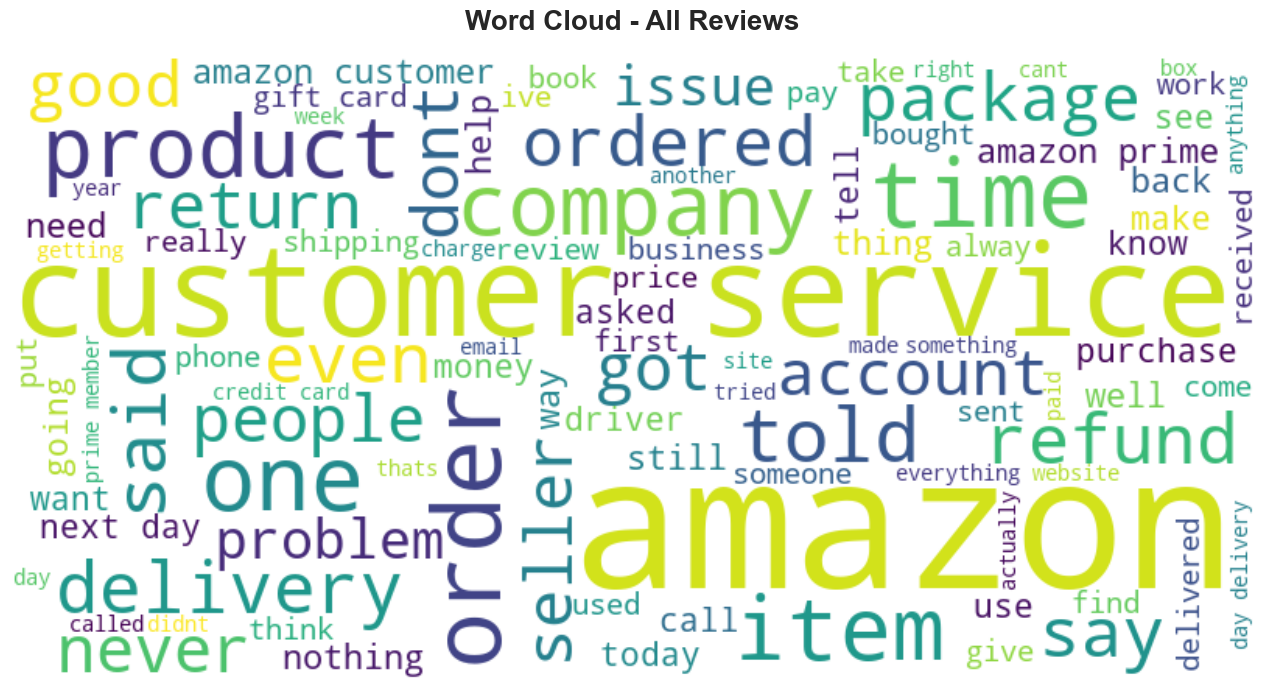

In [27]:
# Word Cloud for All Reviews
all_text = ' '.join(data['Processed_Text'])
generate_wordcloud(all_text, 'Word Cloud - All Reviews', 'viridis')

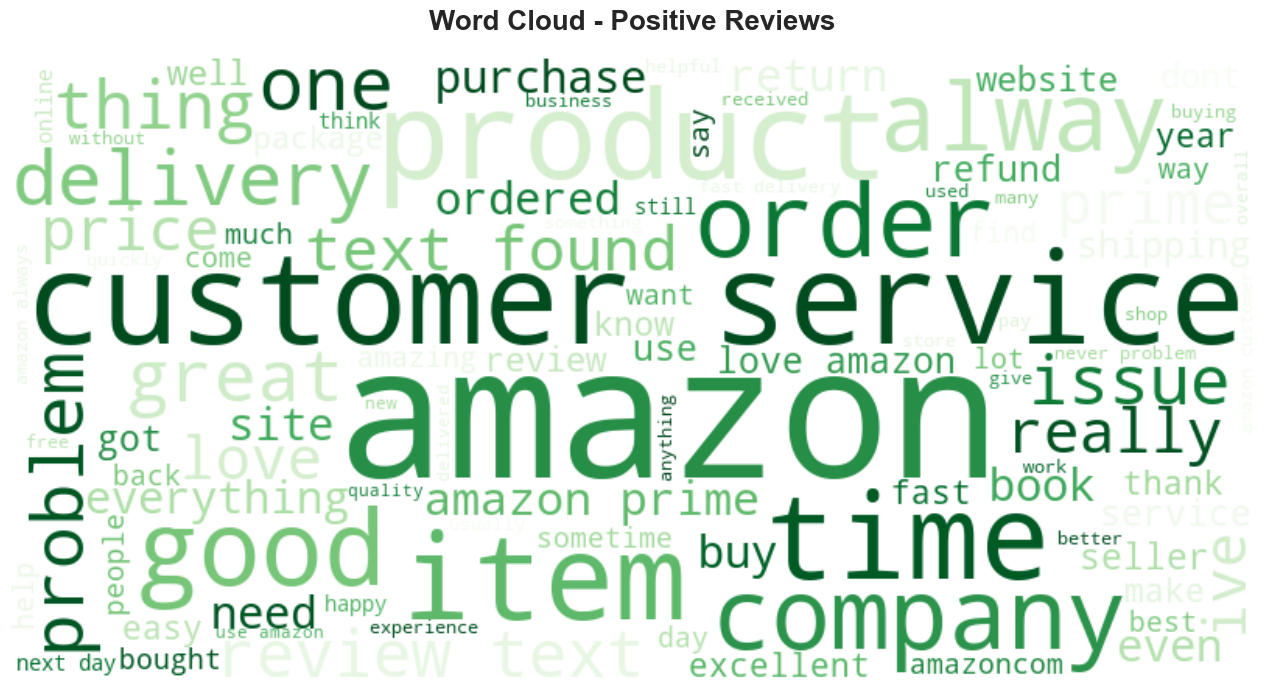

In [28]:
# Word Cloud for Positive Reviews
positive_text = ' '.join(data[data['Sentiment'] == 'Positive']['Processed_Text'])
generate_wordcloud(positive_text, 'Word Cloud - Positive Reviews', 'Greens')

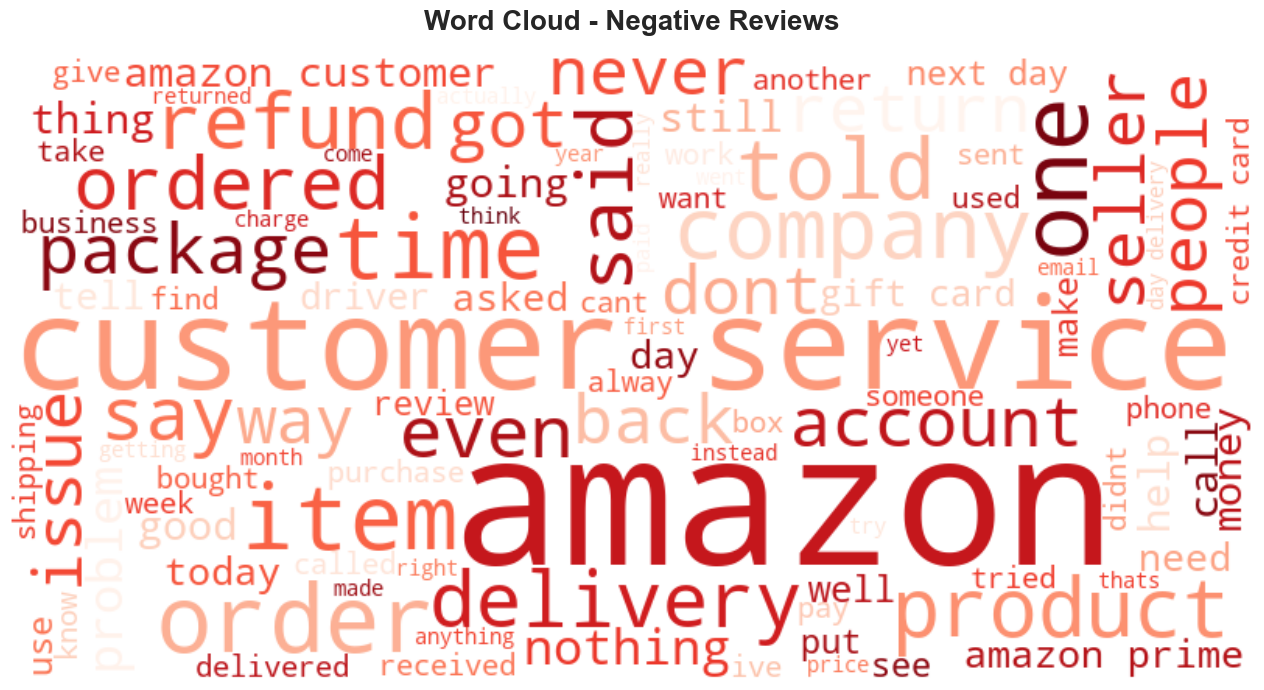

In [29]:
# Word Cloud for Negative Reviews
negative_text = ' '.join(data[data['Sentiment'] == 'Negative']['Processed_Text'])
generate_wordcloud(negative_text, 'Word Cloud - Negative Reviews', 'Reds')

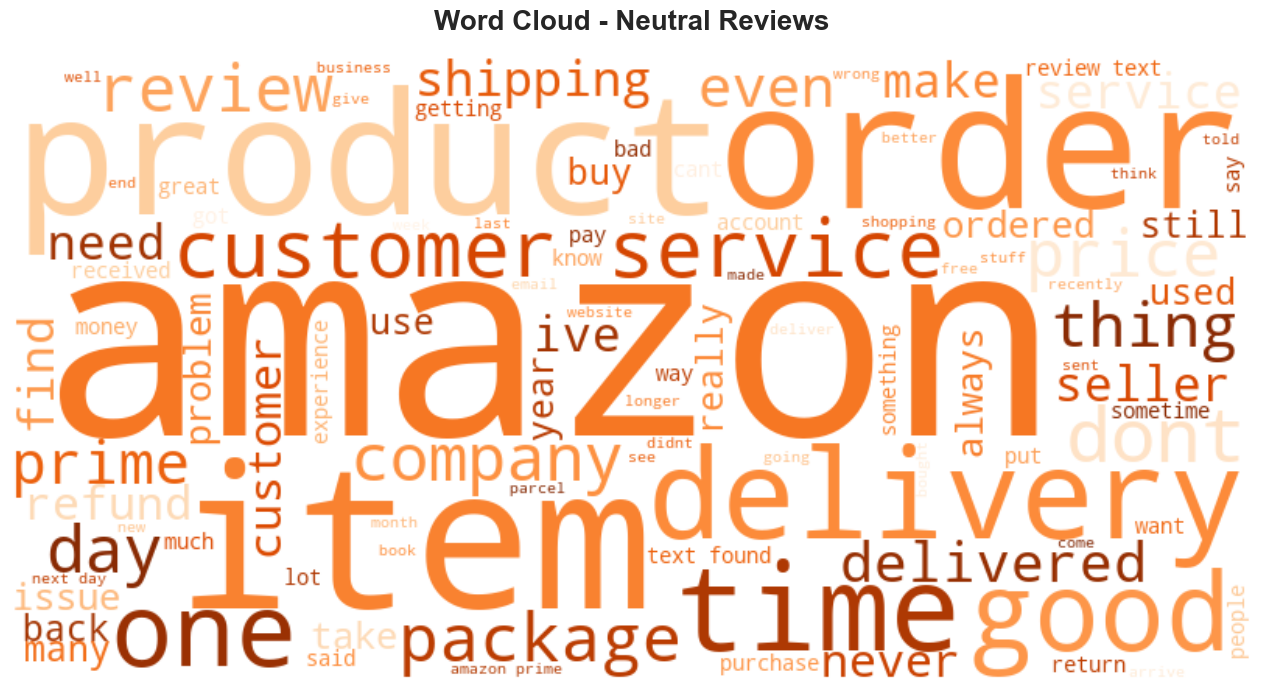

In [30]:
# Word Cloud for Neutral Reviews
if len(data[data['Sentiment'] == 'Neutral']) > 0:
    neutral_text = ' '.join(data[data['Sentiment'] == 'Neutral']['Processed_Text'])
    generate_wordcloud(neutral_text, 'Word Cloud - Neutral Reviews', 'Oranges')

In [31]:
# Most common words by sentiment
from collections import Counter

def get_top_words(text_series, n=20):
    """
    Get top N words from text series
    """
    all_words = ' '.join(text_series).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

print("\n" + "=" * 50)
print("TOP 20 WORDS BY SENTIMENT")
print("=" * 50)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    if len(data[data['Sentiment'] == sentiment]) > 0:
        print(f"\n{sentiment.upper()} Reviews:")
        top_words = get_top_words(data[data['Sentiment'] == sentiment]['Processed_Text'])
        for word, freq in top_words:
            print(f"  {word}: {freq}")


TOP 20 WORDS BY SENTIMENT

POSITIVE Reviews:
  amazon: 4791
  service: 2032
  customer: 1529
  always: 1455
  great: 1306
  time: 1279
  delivery: 1251
  good: 1235
  item: 1166
  product: 1119
  prime: 980
  order: 884
  price: 854
  review: 825
  love: 797
  get: 789
  day: 788
  problem: 740
  company: 740
  never: 711

NEGATIVE Reviews:
  amazon: 24771
  customer: 10575
  service: 9179
  item: 8245
  delivery: 6864
  day: 6847
  time: 6697
  order: 6681
  get: 6542
  account: 5153
  refund: 4759
  prime: 4494
  dont: 4347
  would: 4332
  one: 4091
  never: 3898
  money: 3742
  company: 3708
  even: 3648
  back: 3633

NEUTRAL Reviews:
  amazon: 1051
  item: 383
  delivery: 380
  customer: 333
  service: 324
  order: 314
  time: 314
  day: 302
  get: 297
  product: 279
  prime: 275
  good: 257
  review: 201
  dont: 190
  one: 184
  like: 180
  would: 175
  shipping: 156
  package: 146
  price: 145


## 8. Prepare Data for BiLSTM Model

In [33]:
print("=" * 50)
print("PREPARING DATA FOR BILSTM MODEL")
print("=" * 50)

# Encode sentiment labels
label_encoder = LabelEncoder()
data['Sentiment_Encoded'] = label_encoder.fit_transform(data['Sentiment'])

print("\nSentiment Encoding:")
for label, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {label}: {encoded}")

# Prepare features and labels
X = data['Processed_Text'].values
y = data['Sentiment_Encoded'].values

print(f"\nTotal samples: {len(X)}")
print(f"Feature shape: {X.shape}")
print(f"Label shape: {y.shape}")

PREPARING DATA FOR BILSTM MODEL

Sentiment Encoding:
  Negative: 0
  Neutral: 1
  Positive: 2

Total samples: 21055
Feature shape: (21055,)
Label shape: (21055,)


In [34]:
# Tokenization and Padding
MAX_WORDS = 10000  # Maximum number of words to keep
MAX_LEN = 200      # Maximum length of sequences

print("\n" + "=" * 50)
print("TOKENIZATION & PADDING")
print("=" * 50)

# Initialize tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

# Convert texts to sequences
X_sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

print(f"\nVocabulary size: {len(tokenizer.word_index)}")
print(f"Shape after padding: {X_padded.shape}")
print(f"\nExample sequence (first 10 tokens):")
print(X_padded[0][:10])


TOKENIZATION & PADDING

Vocabulary size: 34755
Shape after padding: (21055, 200)

Example sequence (first 10 tokens):
[1646  162  117    9  792 1665  346  208  637  461]


In [35]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "=" * 50)
print("TRAIN-TEST SPLIT")
print("=" * 50)
print(f"\nTraining set size: {len(X_train)} ({len(X_train)/len(X_padded)*100:.1f}%)")
print(f"Test set size: {len(X_test)} ({len(X_test)/len(X_padded)*100:.1f}%)")

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

print("\nClass distribution in training set:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    sentiment_name = label_encoder.inverse_transform([label])[0]
    print(f"  {sentiment_name}: {count} ({count/len(y_train)*100:.1f}%)")


TRAIN-TEST SPLIT

Training set size: 16844 (80.0%)
Test set size: 4211 (20.0%)

Training set shape: (16844, 200)
Test set shape: (4211, 200)

Class distribution in training set:
  Negative: 11480 (68.2%)
  Neutral: 708 (4.2%)
  Positive: 4656 (27.6%)


## 9. Build BiLSTM Deep Learning Model

In [37]:
print("=" * 50)
print("BUILDING BILSTM MODEL")
print("=" * 50)

# Model parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.3
NUM_CLASSES = len(label_encoder.classes_)

# Build model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    
    # Spatial Dropout
    SpatialDropout1D(DROPOUT_RATE),
    
    # Bidirectional LSTM layer 1
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True, dropout=DROPOUT_RATE, recurrent_dropout=0.2)),
    
    # Bidirectional LSTM layer 2
    Bidirectional(LSTM(LSTM_UNITS//2, dropout=DROPOUT_RATE, recurrent_dropout=0.2)),
    
    # Dense layers
    Dense(64, activation='relu'),
    Dropout(DROPOUT_RATE),
    
    Dense(32, activation='relu'),
    Dropout(DROPOUT_RATE),
    
    # Output layer
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()

BUILDING BILSTM MODEL

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_bilstm_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

In [39]:
# Train the model
print("\n" + "=" * 50)
print("TRAINING BILSTM MODEL")
print("=" * 50)
print("\nThis may take several minutes...\n")

BATCH_SIZE = 64
EPOCHS = 20

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")


TRAINING BILSTM MODEL

This may take several minutes...

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7446 - loss: 0.6821
Epoch 1: val_accuracy improved from None to 0.88008, saving model to best_bilstm_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 610s 3s/step - accuracy: 0.8213 - loss: 0.5174 - val_accuracy: 0.8801 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8977 - loss: 0.3398
Epoch 2: val_accuracy improved from 0.88008 to 0.88810, saving model to best_bilstm_model.h5


211/211 ━━━━━━━━━━━━━━━━━━━━ 683s 3s/step - accuracy: 0.9014 - loss: 0.3249 - val_accuracy: 0.8881 - val_loss: 0.3674 - learning_rate: 0.0010
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9174 - loss: 0.2715
Epoch 3: val_accuracy did not improve from 0.88810
211/211 ━━━━━━━━━━━━━━━━━━━━ 605s 3s/step - accuracy: 0.9176 - loss: 0.2694 - val_accuracy: 0.8831 - val_loss: 0.3887 - learning_rate: 0.0010
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9306 - loss: 0.2186
Epoch 4: val_accuracy did not improve from 0.88810
211/211 ━━━━━━━━━━━━━━━━━━━━ 635s 3s/step - accuracy: 0.9259 - loss: 0.2347 - val_accuracy: 0.8845 - val_loss: 0.4082 - learning_rate: 0.0010
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9310 - loss: 0.2123
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.88810
211/211 ━━━━━━━━━━━━━━━━━━━━ 536s 3s/step - accuracy: 0.9297 - loss: 0.2188 - val_accurac

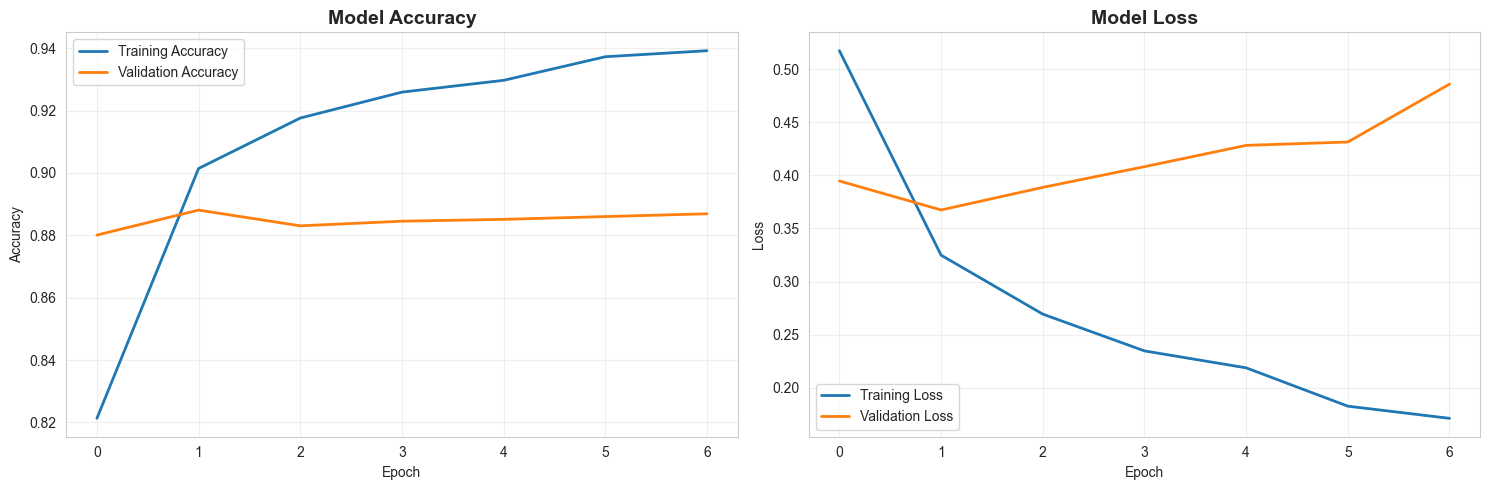

In [40]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Model Evaluation

In [42]:
# Make predictions
print("=" * 50)
print("MODEL EVALUATION")
print("=" * 50)

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy*100:.2f}%")

# Classification report
print("\n" + "=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

MODEL EVALUATION
132/132 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step

Test Accuracy: 89.10%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Negative       0.92      0.94      0.93      2870
     Neutral       0.00      0.00      0.00       177
    Positive       0.82      0.89      0.85      1164

    accuracy                           0.89      4211
   macro avg       0.58      0.61      0.60      4211
weighted avg       0.85      0.89      0.87      4211



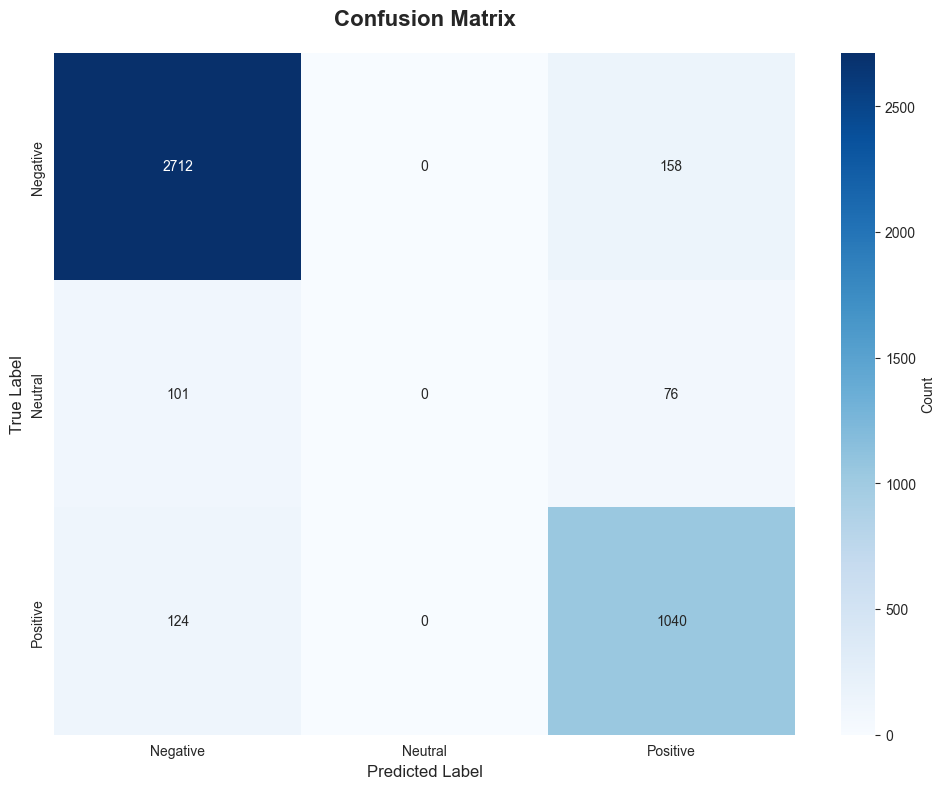


PER-CLASS ACCURACY
Negative: 94.49%
Neutral: 0.00%
Positive: 89.35%


In [43]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n" + "=" * 50)
print("PER-CLASS ACCURACY")
print("=" * 50)
for i, sentiment in enumerate(label_encoder.classes_):
    class_accuracy = cm[i, i] / cm[i].sum() * 100
    print(f"{sentiment}: {class_accuracy:.2f}%")

In [44]:
# Sample predictions
print("\n" + "=" * 50)
print("SAMPLE PREDICTIONS")
print("=" * 50)

# Get sample indices
sample_indices = np.random.choice(len(X_test), 5, replace=False)

for idx in sample_indices:
    true_label = label_encoder.inverse_transform([y_test[idx]])[0]
    pred_label = label_encoder.inverse_transform([y_pred[idx]])[0]
    confidence = y_pred_proba[idx][y_pred[idx]] * 100
    
    # Get original text
    original_idx = data.index[idx]
    original_text = data.loc[original_idx, 'Review Text']
    
    print(f"\n--- Sample {idx} ---")
    print(f"Review: {original_text[:150]}...")
    print(f"True Sentiment: {true_label}")
    print(f"Predicted Sentiment: {pred_label}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Correct: {'✅' if true_label == pred_label else '❌'}")


SAMPLE PREDICTIONS

--- Sample 4052 ---
Review: The app has been super buggy and frankly impossible to add my address to. It just says uh oh something went wrong. Their website isn't much better and...
True Sentiment: Negative
Predicted Sentiment: Negative
Confidence: 99.75%
Correct: ✅

--- Sample 4095 ---
Review: I tried to reset my password for my amazon account, got the email with OTP (one time password) and then it shows something like: "for security reasons...
True Sentiment: Negative
Predicted Sentiment: Negative
Confidence: 99.68%
Correct: ✅

--- Sample 782 ---
Review: I have been an amazon customer for many years and I find the delivery service to be very poor. I have left clear instructions for all my deliveries. D...
True Sentiment: Negative
Predicted Sentiment: Negative
Confidence: 99.58%
Correct: ✅

--- Sample 2254 ---
Review: Use Amazon a lot, but the delivery service is getting worse. They are nowhere near as reliable as they used to be, even prime orders are not being d

## 11. Save Model and Tokenizer

In [46]:
import pickle

print("=" * 50)
print("SAVING MODEL & ARTIFACTS")
print("=" * 50)

# Save the model
model.save('amazon_sentiment_bilstm_model.h5')
print("✅ Model saved as 'amazon_sentiment_bilstm_model.h5'")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✅ Label encoder saved as 'label_encoder.pkl'")

# Save model configuration
model_config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_LEN': MAX_LEN,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'LSTM_UNITS': LSTM_UNITS,
    'classes': label_encoder.classes_.tolist()
}

with open('model_config.pkl', 'wb') as f:
    pickle.dump(model_config, f)
print("✅ Model configuration saved as 'model_config.pkl'")

print("\n✅ All artifacts saved successfully!")

SAVING MODEL & ARTIFACTS
✅ Model saved as 'amazon_sentiment_bilstm_model.h5'
✅ Tokenizer saved as 'tokenizer.pkl'
✅ Label encoder saved as 'label_encoder.pkl'
✅ Model configuration saved as 'model_config.pkl'

✅ All artifacts saved successfully!


## 12. Gradio Interface for Interactive Predictions

In [ ]:
# Prediction function for Gradio
def predict_sentiment(review_text):
    """
    Predict sentiment for a given review text
    """
    if not review_text or len(review_text.strip()) == 0:
        return "Please enter a review text.", {}
    
    # Preprocess the text
    cleaned = clean_text(review_text)
    processed = preprocess_text(cleaned)
    
    if not processed:
        return "Unable to process the text. Please try again.", {}
    
    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([processed])
    padded = pad_sequences(sequence, maxlen=MAX_LEN, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(padded, verbose=0)
    predicted_class = np.argmax(prediction[0])
    predicted_sentiment = label_encoder.inverse_transform([predicted_class])[0]
    confidence = prediction[0][predicted_class] * 100
    
    # Create confidence scores for all classes
    confidences = {}
    for i, sentiment in enumerate(label_encoder.classes_):
        confidences[sentiment] = float(prediction[0][i])
    
    # Result text
    result = f"""## 🎯 Prediction Results

**Sentiment:** {predicted_sentiment}
**Confidence:** {confidence:.2f}%

---

**Processed Text:** {processed[:200]}...
"""
    
    return result, confidences

In [ ]:
# Create Gradio interface
print("=" * 50)
print("LAUNCHING GRADIO INTERFACE")
print("=" * 50)

# Example reviews
examples = [
    ["I love Amazon! Great service and fast delivery. Highly recommend!"],
    ["Terrible experience. My package was lost and customer service was unhelpful."],
    ["The product was okay, nothing special. Delivery was on time."],
    ["Amazon Prime is absolutely worth it! I get all my orders super fast and the customer service is excellent."],
    ["Worst online shopping experience ever. They charged me twice and refused to refund. Stay away!"]
]

# Create interface
iface = gr.Interface(
    fn=predict_sentiment,
    inputs=[
        gr.Textbox(
            label="Enter Amazon Review",
            placeholder="Type your review here...",
            lines=5
        )
    ],
    outputs=[
        gr.Markdown(label="Prediction Results"),
        gr.Label(label="Confidence Scores", num_top_classes=3)
    ],
    title="🌟 Amazon Review Sentiment Analyzer",
    description="""### Analyze the sentiment of Amazon reviews using BiLSTM Deep Learning
    
This model classifies reviews into **Positive**, **Negative**, or **Neutral** sentiments.
    
**How to use:**
1. Enter an Amazon review in the text box
2. Click 'Submit' to get the sentiment prediction
3. View the predicted sentiment and confidence scores

**Model Details:**
- Architecture: Bidirectional LSTM (BiLSTM)
- Training Data: Amazon Customer Reviews
- Test Accuracy: {:.2f}%
""".format(accuracy * 100),
    examples=examples,
    theme="default",
    article="""### About This Model
    
This sentiment analysis model uses a **Bidirectional LSTM (BiLSTM)** architecture, which is particularly 
effective for sequence data like text. The model processes reviews in both forward and backward directions, 
capturing contextual information from both past and future words.

**Model Architecture:**
- Embedding Layer (128 dimensions)
- Bidirectional LSTM Layers (64 units)
- Dense Layers with Dropout
- Softmax Output Layer

**Applications:**
- Customer feedback analysis
- Product review monitoring
- Brand sentiment tracking
- Quality assurance automation
"""
)

# Launch interface
print("\n🚀 Launching Gradio interface...\n")
iface.launch(share=True, debug=True)